# Final_PJT 

1. 데이터 summary & read
<br></br>
2. EDA
- 고객
  - 고객 state에 따른 분포도
  - 가격별 고객 state 
  - 배송비별 고객 state
  - city에 따른 고객 분포도

- 상품
  - 상관계수
  - 카테고리별 주문 수
  - 지역별 best 상품
  - 카테고리별 상품 수
  - 상품 크기 분포

- 주문
  - 주문별 결제 수단
  - 주문 상태'취소'
  - 일자(년도, 월, 요일, 시간)에 따른 주문건수
  - 지역(state, city)에 따른 주문건수

- 판매
  - state별 판매자 분포
  - 카테고리 판매량
  - seller_id별 상품판매
  - 상품판매에 따른 매출
  - 상품유통서비스세(tax) 와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

- 금액
  - 주문별 결제수단 확인
  - 날짜에 따른 가격변화
  
- 리뷰
  - 리뷰 평점 분포
  - WordCloud
  - review_score기준 데이터 분리 후 N-Gram 분석
  
- 배송
  - order_status를 활용한 분석
  - 배송날짜에 따른 유통과정 date 파악
  - 날짜에 따른 배송상태
  - 배송지역
<br></br>

---

## 1. 데이터 summary 및 read

출처 : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- 1) olist_customers_dataset
- 2) olist_geolocation_dataset
- 3) olist_order_items_dataset
- 4) olist_order_payments_dataset
- 5) olist_order_reviews_dataset
- 6) olist_orders_dataset
- 7) olist_products_dataset
- 8) olist_sellers_dataset
- 9) product_category_name_translation

### 1) 라이브러리 및 데이터 로드

In [ ]:
#!pip install folium
#!pip install mysql-connector-python
# !pip install pymysql

# !pip install sqlalchemy pymysql

In [278]:
# 라이브러리 로드
import mysql.connector
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
import folium
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

plt.rcParams['axes.unicode_minus'] = False
rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
olist_customer = pd.read_csv('../dataset/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('../dataset/olist_products_dataset.csv')
olist_sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
olist_products_name_translation = pd.read_csv("../dataset/product_category_name_translation.csv")

In [280]:
# 각 데이터셋의 shape 확인
def shape_each_dataset(df, dataset_name="df"):
    print(f"{dataset_name} 의 데이터는 {df.shape[0]} dataset /  {df.shape[1]} 의 열로 구성")
    
    return df.shape[0], df.shape[1]

In [281]:
customer_r, customer_c = shape_each_dataset(olist_customer, "Olist Customer")
geolocation_r, geolocation_c = shape_each_dataset(olist_geolocation, "Olist Geolocation")
order_items_r, order_items_c = shape_each_dataset(olist_order_items, "Olist Order Items")
order_payments_r, order_payments_c = shape_each_dataset(olist_order_payments, "Olist Order Payments")
order_reviews_r, order_reviews_c = shape_each_dataset(olist_order_reviews, "Olist Order Reviews")
orders_r, orders_c = shape_each_dataset(olist_orders, "Olist Orders")
products_r, products_c = shape_each_dataset(olist_products, "Olist Products")
sellers_r, sellers_c = shape_each_dataset(olist_sellers, "Olist Sellers")

Olist Customer 의 데이터는 99441 dataset /  5 의 열로 구성
Olist Geolocation 의 데이터는 1000163 dataset /  5 의 열로 구성
Olist Order Items 의 데이터는 112650 dataset /  7 의 열로 구성
Olist Order Payments 의 데이터는 103886 dataset /  5 의 열로 구성
Olist Order Reviews 의 데이터는 99224 dataset /  7 의 열로 구성
Olist Orders 의 데이터는 99441 dataset /  8 의 열로 구성
Olist Products 의 데이터는 32951 dataset /  9 의 열로 구성
Olist Sellers 의 데이터는 3095 dataset /  4 의 열로 구성


AWS RDS Database 연결

In [ ]:
# MySQL 연결 정보
host = 'database-1.crtsqbi21zdv.ap-northeast-1.rds.amazonaws.com'
port = 3306
user = 'admin'
password = 'zerobase'
database = 'zerobase'

# 데이터베이스 연결
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')
conn=engine.connect()


# 데이터 
table_name = ['customer', 'geolocation', 'order_items','order_payments','order_reviews','orders','products','sellers','products_name_translation']
olist_customer.to_sql(name='customer', con=engine, if_exists='replace', index=False)

olist_order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=False)
olist_order_payments.to_sql(name='order_payments', con=engine, if_exists='replace', index=False)
olist_order_reviews.to_sql(name='order_reviews', con=engine, if_exists='replace', index=False)
olist_orders.to_sql(name='orders', con=engine, if_exists='replace', index=False)
olist_products.to_sql(name='products', con=engine, if_exists='replace', index=False)
olist_sellers.to_sql(name='sellers', con=engine, if_exists='replace', index=False)
olist_products_name_translation.to_sql(name='products_name_translation', con=engine, if_exists='replace', index=False)
# olist_geolocation.to_sql(name='geolocation', con=engine, if_exists='replace', index=False)

In [283]:
# https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score
# 쿼리문 작성하여 출력

def get_query(query):   
  return pd.read_sql_query(text(query), conn)



In [284]:
# 데이터 확인

query="""
show tables;
"""
    
get_query(query)

,Tables_in_zerobase
0,customer
1,order_items
2,order_payments
3,order_reviews
4,orders
5,products
6,products_name_translation
7,sellers
8,state_tax


In [181]:
datasets = [olist_customer, olist_geolocation, olist_order_items, 
            olist_order_payments,  olist_order_reviews, olist_orders, 
            olist_products, olist_sellers, olist_products_name_translation]

titles = ["customers", "geolocation", "items", "payments", "reviews",
         "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='tab20c')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_purchase_year, order_purchase_month, order_purchase_day, order_purchase_dayofweek, order_purchase_date, order_purchase_hour, order_purchase_year_month, average_order_purchase_timestamp",99441,16,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


---

## 2. EDA

### 5) 금액

#### 주문별 결제수단 확인

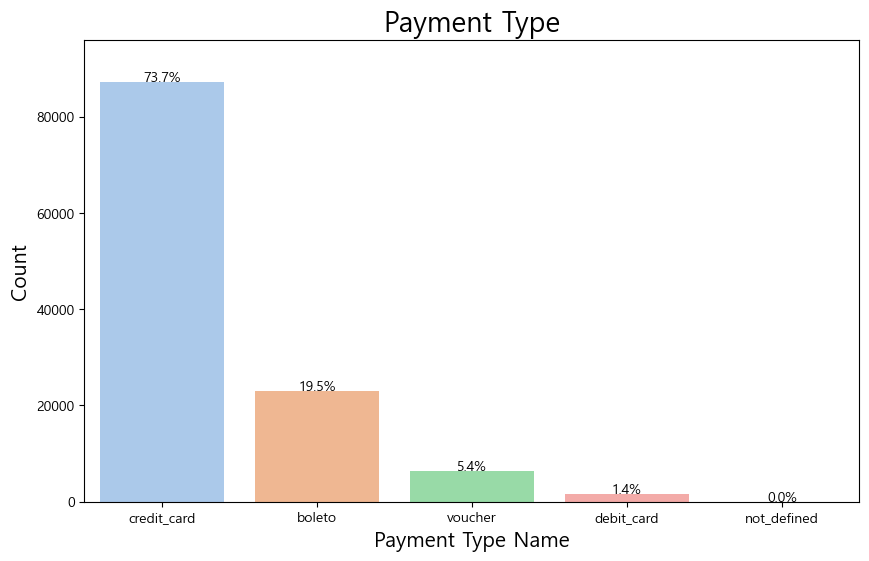

In [446]:
count_plot(df_jo, df_jo['payment_type'], 'pastel', 'Payment Type', 'Payment Type Name', 'Count')

- 모든 판매건의 결제수단 중 credit card가 73% 이상으로 가장 일반적인 결제 수단이며 그 다음으로 boleto(19.5%), voucher(5.4%) 등이 많이 사용

In [447]:
time = df_jo[['order_id', 'order_purchase_timestamp', 'price']].set_index('order_purchase_timestamp', inplace=False)

df_time_jo = pd.DataFrame(time.resample('W')['price'].sum())
# 마지막 6주 연속으로 price가 0이어서 이상치로 판단해 제거
df_time_jo.drop(df_time_jo.tail(6).index, inplace=True)
df_time_jo

,price
order_purchase_timestamp,
2016-09-04,72.89
2016-09-11,59.50
2016-09-18,134.97
2016-09-25,0.00
2016-10-02,100.00
...,...
2018-08-12,288122.23
2018-08-19,257414.84
2018-08-26,128453.12


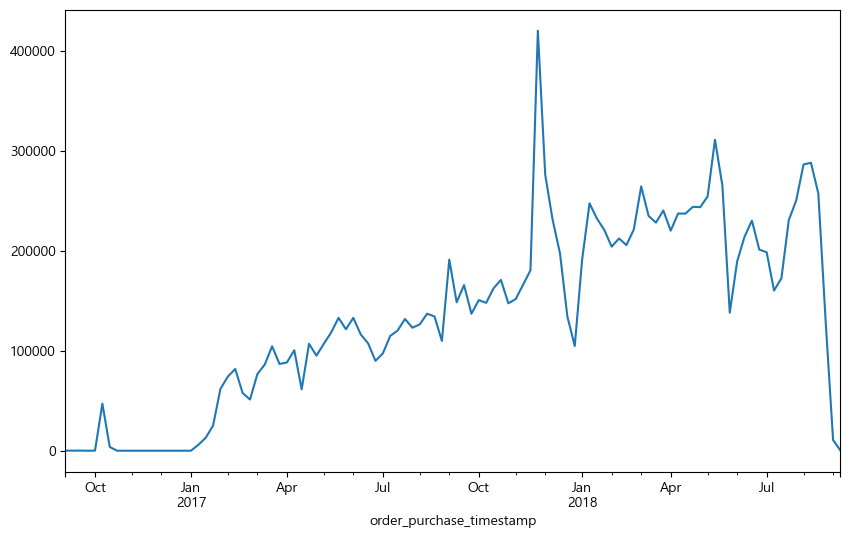

In [448]:
df_time_jo['price'].plot(figsize=(10,6));

---

### 6) 리뷰

#### 리뷰 평점 분포

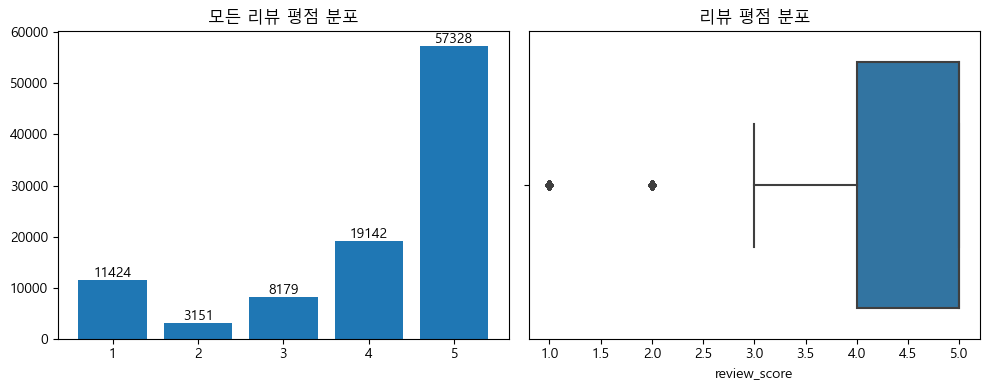

In [265]:
query="""
select review_score, count(*) cnt
from order_reviews 
group by review_score
order by review_score;
"""

counts=get_query(query)


fig, axs =  plt.subplots(1, 2, figsize=(10, 4))

bars = axs[0].bar(counts.review_score, counts.cnt)
axs[0].set_title('모든 리뷰 평점 분포')

for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

sns.boxplot(data=olist_order_reviews, x='review_score')
axs[1].set_title('리뷰 평점 분포')

plt.tight_layout()
plt.show()

In [266]:
# 리뷰 제목은 null값이지만, 내용은 있음 -> 31138
# 리뷰 제목은 있지만, 내용은 null값 -> 1729

print('리뷰 제목 o, 내용 x :' ,len(olist_order_reviews[(olist_order_reviews['review_comment_title'].isnull()) & (olist_order_reviews['review_comment_message'].notnull())]))
print('리뷰 제목 x, 내용 o :' , len(olist_order_reviews[(olist_order_reviews['review_comment_title'].notnull()) & (olist_order_reviews['review_comment_message'].isnull())]))

# 리뷰, 제목 둘 다 null값 : 56518

review_null=olist_order_reviews[(olist_order_reviews['review_comment_title'].isnull()) & (olist_order_reviews['review_comment_message'].isnull())]

리뷰 제목 o, 내용 x : 31138
리뷰 제목 x, 내용 o : 1729


#### 평점 별 리뷰 쓰지 않은 비율

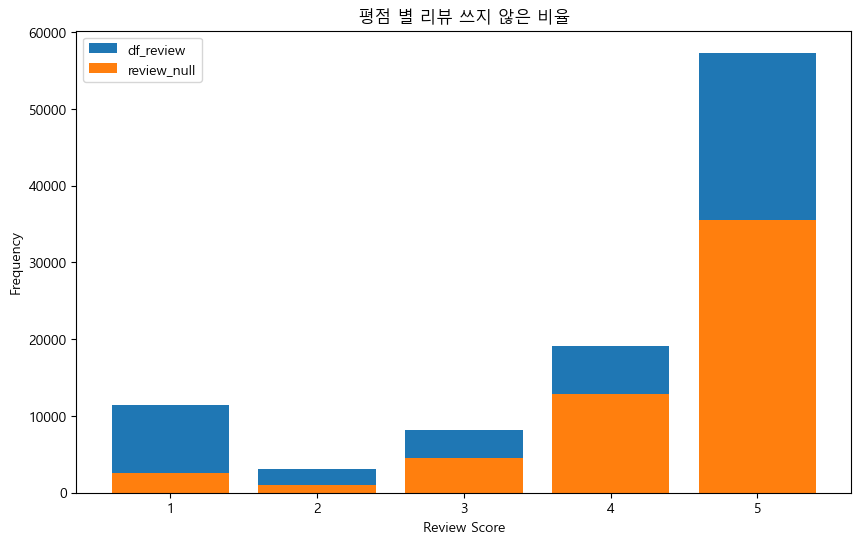

In [267]:
plt.figure(figsize=(10, 6))
plt.bar(olist_order_reviews.review_score.value_counts().index, olist_order_reviews.review_score.value_counts().values, label='df_review')
plt.bar(review_null.review_score.value_counts().index, review_null.review_score.value_counts().values, label='review_null')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('평점 별 리뷰 쓰지 않은 비율')
plt.legend()
plt.show()

- 4점을 준 고객이 리뷰를 많이 씀
- 1점 준 고객 리뷰 적게 씀

In [449]:
# NaN값이 굉장히 많아서 결측치를 제거해준다.
olist_order_reviews_tmp = olist_order_reviews.dropna(subset=['review_comment_message'])

#### 리뷰에 따른 wordcloud

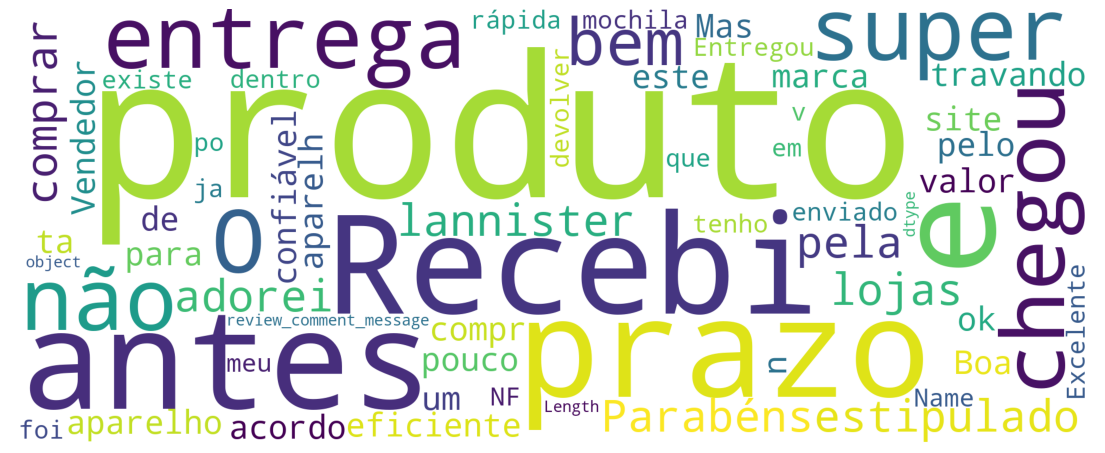

In [450]:
from wordcloud import WordCloud, STOPWORDS

stop_words = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words, width = 2000, height = 800).generate(str(olist_order_reviews_tmp['review_comment_message']))

plt.figure(figsize=(14,14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### review_score 기준으로 데이터 나누기

In [451]:
from collections import defaultdict
review_score_bad = olist_order_reviews_tmp[olist_order_reviews_tmp["review_score"]<3]
review_score_good = olist_order_reviews_tmp[olist_order_reviews_tmp["review_score"]>=3]

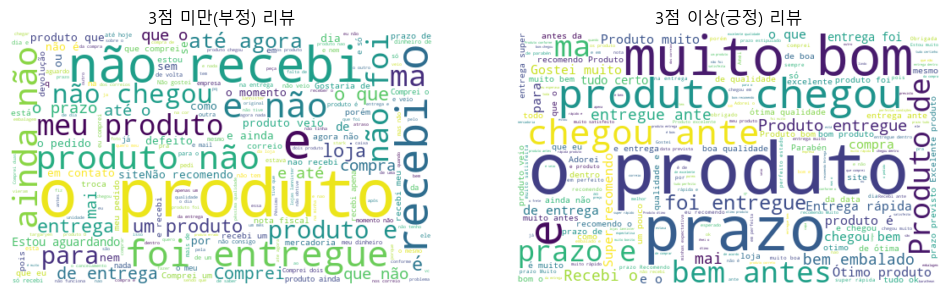

In [452]:
# 리뷰 데이터 추출

plt.figure(figsize=(12,7))

# WordCloud 생성
wordcloud3 = WordCloud(width=500, height=300, background_color="white").generate(" ".join(olist_order_reviews_tmp[olist_order_reviews_tmp["review_score"]<3]["review_comment_message"]))

# 그래프 출력
plt.subplot(1,2,1)

plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis("off")
plt.title('3점 미만(부정) 리뷰')


wordcloud4 = WordCloud(width=500, height=300, background_color="white").generate(" ".join(olist_order_reviews_tmp[olist_order_reviews_tmp["review_score"]>=3]["review_comment_message"]))

plt.subplot(1,2,2)

plt.imshow(wordcloud4, interpolation="bilinear")
plt.axis("off")
plt.title('3점 이상(긍정) 리뷰')

plt.show()

#### 함수 설정 

In [453]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

#### 1-gram 단위로 분석
- review_score가 3점 미만이면 부정, 3점 이상이면 긍정

In [124]:
# Good
freq_dict = defaultdict(int)
for sent in review_score_good["review_comment_message"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# bad
freq_dict = defaultdict(int)
for sent in review_score_bad["review_comment_message"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of score 3 to 5", 
                                          "Frequent words of score 1 to 2"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=800, width=1000, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 1")
py.iplot(fig, filename='word-plots')

- produto : 제품 / muilto : 매우 / antes : ~ 전에
- nao : 아니오 / que : 무엇

In [125]:
# Good
freq_dict = defaultdict(int)
for sent in review_score_good["review_comment_message"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# bad
freq_dict = defaultdict(int)
for sent in review_score_bad["review_comment_message"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of score 3 to 5", 
                                          "Frequent words of score 1 to 2"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=800, width=1200, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 1")
py.iplot(fig, filename='word-plots')

- antes prazo : 마감일전에 / muito bom : 매우좋은 / chegou antes : 전에 도착
- nao recebi : 받지못했다 / ainda nao : 아직아님 / produto nao : 제품없음
- 어느정도 부정과 긍정단어 사이의 차이가 보인다.

In [126]:
# Good
freq_dict = defaultdict(int)
for sent in review_score_good["review_comment_message"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# bad
freq_dict = defaultdict(int)
for sent in review_score_bad["review_comment_message"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of score 3 to 5", 
                                          "Frequent words of score 1 to 2"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=800, width=1400, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 1")
py.iplot(fig, filename='word-plots')

- o produto chegou : 제품이 도착했습니다. / chegou antes prazo : 마감시간전에 도착 / recebi o produto : 나는 제품을 받았다.
- nao recebi o : 나는 받지 않았다 / recebi o produto : 나는 제품을 받았다.
- 더 큰 차이를 보여주긴 하지만, 긍정과 부정사이에 겹치는 문장들이 존재한다.

In [127]:
# Good
freq_dict = defaultdict(int)
for sent in review_score_good["review_comment_message"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(30), 'blue')

# bad
freq_dict = defaultdict(int)
for sent in review_score_bad["review_comment_message"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(30), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of score 3 to 5", 
                                          "Frequent words of score 1 to 2"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=800, width=1600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 1")
py.iplot(fig, filename='word-plots')

- o produto foi entrgue : 제품이 배송되었습니다 / o produto chegou antes : 전에 도착한 제품 / produto chegou antes prazo : 마감일 전에 도착한 제품
- nao recebi o produto : 상품을 받지 못했다. / ainda ano recebi o : 나는 여전히 / o produto nao foi : 제품은 아니었다.
- 이제 극명한 차이를 보이고있다.

---